In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/'CS 247'/'Project'
%ls

Mounted at /content/drive
/content/drive/My Drive/CS 247/Project
deeplog.ipynb  loglizer/


In [2]:
run_models = ['PCA', 'InvariantsMiner', 'LogClustering', 'IsolationForest', 'LR', 
              'SVM', 'DecisionTree']

In [3]:
#!git clone https://github.com/logpai/loglizer.git
%cd loglizer
#!pip install -r requirements.txt

/content/drive/My Drive/CS 247/Project/loglizer


In [4]:
import sys
sys.path.append('../')
from loglizer import dataloader
from loglizer.models import DeepLog
from loglizer import preprocessing
from loglizer.preprocessing import Vectorizer, Iterator


In [5]:
batch_size = 32
hidden_size = 32
num_directions = 2
topk = 5
train_ratio = 0.2
window_size = 10
epoches = 2
num_workers = 2
device = 2 

In [6]:
#struct_log = '../MyData/' # The structured log file
#label_file = '../MyData/anomaly_label.csv' # The anomaly label file
curr_path = "/content/drive/My Drive/CS 247/Project/loglizer"
#struct_log = '/content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/HDFS.npz'
struct_log = '/content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/HDFS_100k.log_structured.csv'
label_file = '/content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/anomaly_label.csv' # The anomaly label file

In [ ]:
DATA = []
DATA.append(dataloader.load_HDFS(struct_log,
                                                           window='session', 
                                                           train_ratio=0.8,
                                                           split_type='uniform'))


====== Input data summary ======
Loading /content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/HDFS_100k.log_structured.csv


KeyboardInterrupt: ignored

### N-gram baseline

In [ ]:
class N_gram(object):

  def __init__(self, x_train, x_test, n = 3):
    self.vocab = {}
    self.ngram_counts = {}
    #ids = set(x_train.SessionId)
    #for id in ids:
    for i,seq in enumerate(x_train.EventSequence):
      m = len(seq)
      for j in range(m - n + 1):
        curr_ngram = seq[j:(j+n)]
        curr_ngram_str = ''.join(curr_ngram)
        if curr_ngram_str not in self.vocab:
          self.vocab[curr_ngram_str] = 1
        else:
          self.vocab[curr_ngram_str] += 1
        if y_train[i] == 0:
          count = np.array([1, 0])
        else:
          count = np.array([0, 1])
        prior_ngram_str = ''.join(curr_ngram[:-1])
        if prior_ngram_str not in self.ngram_counts:
          self.ngram_counts[prior_ngram_str] = count
        else:
          self.ngram_counts[prior_ngram_str] += count
  
  def eval(self, x_test, y_test):
    preds = []
    for i, seq in enumerate(x_test.EventSequence):
      m = len(seq)
      seq_log_prob = np.zeros(2)
      for j in range(m - n + 1):
        curr_ngram = seq[j:(j+n)]
        curr_ngram_str = ''.join(curr_ngram)
        denom = self.vocab.get(curr_ngram_str, 0)
        if denom == 0:
          seq_log_prob += np.log(0.5)
        else:
          prior_ngram_str = ''.join(curr_ngram[:-1])
          num = self.ngram_counts.get(prior_ngram_str, np.zeros(2))
          #print(i, prior_ngram_str, num)
          seq_log_prob += np.log(np.array(num) / denom)
      preds.append(np.argmax(seq_log_prob))
    
    preds = np.array(preds)
    for sess in x_test.SessionId:
      inds = x_test[x_test.SessionId == 11].index.tolist()
      preds[inds[0]:inds[1]] = np.round(np.mean(preds[inds[0]:inds[1]])).astype(int)
    
    print("acc = ", np.mean(preds == y_test))
    return preds

      






In [ ]:
trigram = N_gram(x_train, x_test, 3)
trigram.eval(x_test, y_test)

acc =  0.967373193319642


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
all_pred = np.zeros(y_test.shape)
for i in range(1, 9):
  ngram = N_gram(x_train, x_test, i)
  pred = ngram.eval(x_test, y_test)
  all_pred += pred

all_pred /= 8
print("acc = ", np.mean(all_pred == y_test))


acc =  0.967373193319642
acc =  0.967373193319642


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log


acc =  0.21951408532568684
acc =  0.967373193319642
acc =  0.967373193319642
acc =  0.967373193319642
acc =  0.967373193319642
acc =  0.967373193319642
acc =  0.19777579726430813


### Loglizer base models

In [7]:
from loglizer.models import *
from loglizer import dataloader, preprocessing

In [ ]:
(x_tr, y_train), (x_te, y_test), data_df = dataloader.load_HDFS(struct_log,
                                                           window='session', 
                                                           train_ratio=0.5,
                                                           split_type='uniform')
benchmark_results = []
for _model in run_models:
  print('Evaluating {} on HDFS:'.format(_model))
  if _model == 'PCA':
      feature_extractor = preprocessing.FeatureExtractor()
      x_train = feature_extractor.fit_transform(x_tr, term_weighting='tf-idf', 
                                                normalization='zero-mean')
      model = PCA()
      model.fit(x_train)

  elif _model == 'InvariantsMiner':
      feature_extractor = preprocessing.FeatureExtractor()
      x_train = feature_extractor.fit_transform(x_tr)
      model = InvariantsMiner(epsilon=0.5)
      model.fit(x_train)

  elif _model == 'LogClustering':
      feature_extractor = preprocessing.FeatureExtractor()
      x_train = feature_extractor.fit_transform(x_tr, term_weighting='tf-idf')
      model = LogClustering(max_dist=0.3, anomaly_threshold=0.3)
      model.fit(x_train[y_train == 0, :]) # Use only normal samples for training

  elif _model == 'IsolationForest':
      feature_extractor = preprocessing.FeatureExtractor()
      x_train = feature_extractor.fit_transform(x_tr)
      model = IsolationForest(random_state=2019, max_samples=0.9999, contamination=0.03, 
                              n_jobs=4)
      model.fit(x_train)

  elif _model == 'LR':
      feature_extractor = preprocessing.FeatureExtractor()
      x_train = feature_extractor.fit_transform(x_tr, term_weighting='tf-idf')
      model = LR()
      model.fit(x_train, y_train)

  elif _model == 'SVM':
      feature_extractor = preprocessing.FeatureExtractor()
      x_train = feature_extractor.fit_transform(x_tr, term_weighting='tf-idf')
      model = SVM()
      model.fit(x_train, y_train)

  elif _model == 'DecisionTree':
      feature_extractor = preprocessing.FeatureExtractor()
      x_train = feature_extractor.fit_transform(x_tr, term_weighting='tf-idf')
      model = DecisionTree()
      model.fit(x_train, y_train)

  x_test = feature_extractor.transform(x_te)
  print('Train accuracy:')
  precision, recall, f1 = model.evaluate(x_train, y_train)
  benchmark_results.append([_model + '-train', precision, recall, f1])
  print('Test accuracy:')
  precision, recall, f1 = model.evaluate(x_test, y_test)
  benchmark_results.append([_model + '-test', precision, recall, f1])

  pd.DataFrame(benchmark_results, columns=['Model', 'Precision', 'Recall', 'F1']) #\
  #.to_csv('benchmark_result.csv', index=False)

====== Input data summary ======
Loading /content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/HDFS_100k.log_structured.csv
Total: 7940 instances, train: 3970 instances, test: 3970 instances


ValueError: ignored

In [ ]:
for epoch in [2,5, 10,100]:
  (x_train, window_y_train, y_train), (x_test, window_y_test, y_test) = dataloader.load_HDFS(struct_log, label_file=label_file, window='session', window_size=window_size, train_ratio=train_ratio, split_type='uniform')
    
  feature_extractor = Vectorizer()
  train_dataset = feature_extractor.fit_transform(x_train, window_y_train, y_train)
  test_dataset = feature_extractor.transform(x_test, window_y_test, y_test)

  train_loader = Iterator(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers).iter
  test_loader = Iterator(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers).iter

  model = DeepLog(num_labels=feature_extractor.num_labels, hidden_size=hidden_size, num_directions=2, topk=topk, device=device)
  model.fit(train_loader, epoch)
  print("========")
  print(f"epoch = {epoch}")
  print('Train validation:')
  metrics = model.evaluate(train_loader)

  print('Test validation:')
  metrics = model.evaluate(test_loader)

====== Input data summary ======
Loading /content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/HDFS_100k.log_structured.csv
62 251
Slicing 1587 sessions, with window 10
Slicing done, 8406 windows generated
Slicing 6353 sessions, with window 10
Slicing done, 25807 windows generated
Train: 8406 windows (464/8406 anomaly), 7942/8406 normal
Test: 25807 windows (842/25807 anomaly), 24965/25807 normal
Epoch 1/2, training loss: 2.49930
Epoch 2/2, training loss: 2.32946
epoch = 2
Train validation:
[('window_acc', 0.50809), ('session_acc', 0.78513), ('f1', 0.10026), ('recall', 0.30645), ('precision', 0.05994)]
Test validation:
[('window_acc', 0.1741), ('session_acc', 0.09586), ('f1', 0.04394), ('recall', 0.5259), ('precision', 0.02293)]
====== Input data summary ======
Loading /content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/HDFS_100k.log_structured.csv
62 251
Slicing 1587 sessions, with window 10
Slicing done, 8406 windows generated
Slicing 6353 sessions, with window 10
Slicing done

In [ ]:
for batch_size in [32,64,128,256,512,1024]:
  (x_train, window_y_train, y_train), (x_test, window_y_test, y_test) = dataloader.load_HDFS(struct_log, label_file=label_file, window='session', window_size=window_size, train_ratio=train_ratio, split_type='uniform')
    
  feature_extractor = Vectorizer()
  train_dataset = feature_extractor.fit_transform(x_train, window_y_train, y_train)
  test_dataset = feature_extractor.transform(x_test, window_y_test, y_test)

  train_loader = Iterator(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers).iter
  test_loader = Iterator(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers).iter

  model = DeepLog(num_labels=feature_extractor.num_labels, hidden_size=hidden_size, num_directions=2, topk=topk, device=device)
  model.fit(train_loader, epoches)
  print("========")
  print(f"batch_size = {batch_size}")
  print('Train validation:')
  metrics = model.evaluate(train_loader)

  print('Test validation:')
  metrics = model.evaluate(test_loader)

### N-gram (nltk)

In [ ]:
from itertools import product
import math
import nltk

In [ ]:
import numpy as np
import pandas as pd


In [ ]:
fake_df = pd.DataFrame({"zip_code": np.repeat(["243x2", "2899.8", "5551?", "03754", "14234"], 2)})
fake_df

,zip_code
0,243x2
1,243x2
2,2899.8
3,2899.8
4,5551?
5,5551?
6,03754
7,03754
8,14234
9,14234


In [ ]:
x_train["EventSequence"].values

array([list(['E5', 'E5', 'E5', 'E22', 'E11', 'E9', 'E11', 'E9', 'E11', 'E9']),
       list(['E5', 'E5', 'E22', 'E11', 'E9', 'E11', 'E9', 'E11', 'E9', 'E26']),
       list(['E5', 'E22', 'E11', 'E9', 'E11', 'E9', 'E11', 'E9', 'E26', 'E26']),
       ...,
       list(['E5', 'E5', 'E11', 'E9', 'E11', 'E9', 'E26', 'E26', 'E11', 'E9']),
       list(['E5', 'E11', 'E9', 'E11', 'E9', 'E26', 'E26', 'E11', 'E9', 'E26']),
       list(['E11', 'E9', 'E11', 'E9', 'E26', 'E26', 'E11', 'E9', 'E26', 'E2'])],
      dtype=object)

In [ ]:
from itertools import groupby

def get_pattern(value):
    pattern = ''
    value = list(str(value))
    for c in value:
        if c.isnumeric():
            pattern += 'd'
        elif c.isalpha():
            pattern += 'l'
        else:
            pattern += 's'
    
    grouped_pattern = [''.join(g) for _, g in groupby(pattern)]
    
    return ''.join([f'{v[0]}({len(v)})' for v in grouped_pattern])

zip_codes = fake_df['zip_code'].values
zip_codes_pattern = [get_pattern(zc) for zc in zip_codes]
zip_codes_pattern

['d(3)l(1)d(1)',
 'd(3)l(1)d(1)',
 'd(4)s(1)d(1)',
 'd(4)s(1)d(1)',
 'd(4)s(1)',
 'd(4)s(1)',
 'd(5)',
 'd(5)',
 'd(5)',
 'd(5)']

In [ ]:
#!pip install "nltk==3.6.2"

     |████████████████████████████████| 1.5MB 6.5MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
x_train

,SessionId,EventSequence
0,0,"[E5, E5, E5, E22, E11, E9, E11, E9, E11, E9]"
1,0,"[E5, E5, E22, E11, E9, E11, E9, E11, E9, E26]"
2,0,"[E5, E22, E11, E9, E11, E9, E11, E9, E26, E26]"
3,0,"[E22, E11, E9, E11, E9, E11, E9, E26, E26, E26]"
4,0,"[E11, E9, E11, E9, E11, E9, E26, E26, E26, E2]"
...,...,...
8401,1586,"[E5, E22, E5, E5, E11, E9, E11, E9, E26, E26]"
8402,1586,"[E22, E5, E5, E11, E9, E11, E9, E26, E26, E11]"
8403,1586,"[E5, E5, E11, E9, E11, E9, E26, E26, E11, E9]"
8404,1586,"[E5, E11, E9, E11, E9, E26, E26, E11, E9, E26]"


In [ ]:
#x_train
#token= x_train.EventSequence[0]
list(zip(*[token[i:] for i in range(3)]))

[('E5', 'E5', 'E5'),
 ('E5', 'E5', 'E22'),
 ('E5', 'E22', 'E11'),
 ('E22', 'E11', 'E9'),
 ('E11', 'E9', 'E11'),
 ('E9', 'E11', 'E9'),
 ('E11', 'E9', 'E11'),
 ('E9', 'E11', 'E9'),
 ('E5', 'E5', 'E5'),
 ('E5', 'E5', 'E22'),
 ('E5', 'E22', 'E11'),
 ('E22', 'E11', 'E9'),
 ('E11', 'E9', 'E11'),
 ('E9', 'E11', 'E9'),
 ('E11', 'E9', 'E11'),
 ('E9', 'E11', 'E9')]

In [ ]:
def ngram_preprocess(x_train, n):
  All_Sess = set(x_train.SessionId)
  Sess_ngrams = []
  for id in All_Sess:
    Sess_ngrams.append(list(zip(*[token[i:] for i in range(3)])))
  pad_seqs_pttrn = [pad_both_ends(seq_p, n) for seq_p in All_pattrns]
  

In [ ]:
def get_pattern(sess_seqs):
  return [''.join(seq) for seq in sess_seqs]

def ngram_preprocess(x_train, n):
  All_Sess = set(x_train.SessionId)
  All_pattrns = []
  for id in All_Sess:
    All_seqs = x_train[x_train.SessionId == id].EventSequence.values
    seq_pttrn = get_pattern(All_seqs)
    All_pattrns += seq_pttrn

  pad_seqs_pttrn = [pad_both_ends(seq_p, n) for seq_p in All_pattrns]
  my_ngrams = [ngrams(psp, n=n) for psp in pad_seqs_pttrn]
  processed_d = {"tokens": my_ngrams}
  return processed_d


In [ ]:
def get_pattern(sess_seqs):
  return [''.join(seq) for seq in sess_seqs]

def ngram_preprocess(x_train, n):
  All_Sess = set(x_train.SessionId)
  All_pattrns = []
  for id in All_Sess:
    All_seqs = x_train[x_train.SessionId == id].EventSequence.values
    seq_pttrn = get_pattern(All_seqs)
    All_pattrns += seq_pttrn

  pad_seqs_pttrn = [pad_both_ends(seq_p, n) for seq_p in All_pattrns]
  my_ngrams = [ngrams(psp, n=n) for psp in pad_seqs_pttrn]
  vocab = list(flatten(pad_both_ends(seq_p, n=n-1) for seq_p in All_pattrns))
  processed_d = {"ngram": my_ngrams, "vocab": vocab}
  return processed_d


class N_GramModel(object):
   def __init__(self, train_data, n, laplace=1):
        self.n = n
        self.laplace = laplace
        self.prcs_dict = ngram_preprocess(train_data, n)
        self.tokens = self.prcs_dict["tokens"]
        self.vocab  = nltk.FreqDist(self.tokens)
        self.model  = self._create_model()
        self.masks  = list(reversed(list(product((0,1), repeat=n))))

  def _smooth(self):
        """Apply Laplace smoothing to n-gram frequency distribution.
        
        Here, n_grams refers to the n-grams of the tokens in the training corpus,
        while m_grams refers to the first (n-1) tokens of each n-gram.
        Returns:
            dict: Mapping of each n-gram (tuple of str) to its Laplace-smoothed 
            probability (float).
        """
        vocab_size = len(self.vocab)

        n_grams = nltk.ngrams(self.tokens, self.n)
        n_vocab = nltk.FreqDist(n_grams)

        m_grams = nltk.ngrams(self.tokens, self.n-1)
        m_vocab = nltk.FreqDist(m_grams)

        def smoothed_count(n_gram, n_count):
            m_gram = n_gram[:-1]
            m_count = m_vocab[m_gram]
            return (n_count + self.laplace) / (m_count + self.laplace * vocab_size)

        return { n_gram: smoothed_count(n_gram, count) for n_gram, count in n_vocab.items() }

    def _create_model(self):
        """Create a probability distribution for the vocabulary of the training corpus.
        
        If building a unigram model, the probabilities are simple relative frequencies
        of each token with the entire corpus.
        Otherwise, the probabilities are Laplace-smoothed relative frequencies.
        Returns:
            A dict mapping each n-gram (tuple of str) to its probability (float).
        """
        if self.n == 1:
            num_tokens = len(self.tokens)
            return { (unigram,): count / num_tokens for unigram, count in self.vocab.items() }
        else:
            return self._smooth()

    def _convert_oov(self, ngram):
        """Convert, if necessary, a given n-gram to one which is known by the model.
        Starting with the unmodified ngram, check each possible permutation of the n-gram
        with each index of the n-gram containing either the original token or <UNK>. Stop
        when the model contains an entry for that permutation.
        This is achieved by creating a 'bitmask' for the n-gram tuple, and swapping out
        each flagged token for <UNK>. Thus, in the worst case, this function checks 2^n
        possible n-grams before returning.
        Returns:
            The n-gram with <UNK> tokens in certain positions such that the model
            contains an entry for it.
        """
        mask = lambda ngram, bitmask: tuple((token if flag == 1 else "<UNK>" for token,flag in zip(ngram, bitmask)))

        ngram = (ngram,) if type(ngram) is str else ngram
        for possible_known in [mask(ngram, bitmask) for bitmask in self.masks]:
            if possible_known in self.model:
                return possible_known


### Log_clustering

In [8]:
from loglizer.models import *
from loglizer import dataloader, preprocessing

In [9]:
max_dist = 0.3 # the threshold to stop the clustering process
anomaly_threshold = 0.3 # the threshold for anomaly detection
train_ratio = 0.2

(X_train, y_train), (X_test, y_test) = dataloader.load_HDFS(struct_log,
                                                            label_file=label_file,
                                                            window='session', 
                                                            train_ratio=train_ratio,
                                                            split_type='uniform')
feature_extractor = preprocessing.FeatureExtractor()
x_train = feature_extractor.fit_transform(X_train, term_weighting='tf-idf')
x_test = feature_extractor.transform(X_test)

model = LogClustering(max_dist=max_dist, anomaly_threshold=anomaly_threshold)
model.fit(x_train[y_train == 0, :]) # Use only normal samples for training

print('Train validation:')
precision, recall, f1 = model.evaluate(x_train, y_train)

print('Test validation:')
precision, recall, f1 = model.evaluate(x_test, y_test)

====== Input data summary ======
Loading /content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/HDFS_100k.log_structured.csv
62 251
Total: 7940 instances, 313 anomaly, 7627 normal
Train: 1587 instances, 62 anomaly, 1525 normal
Test: 6353 instances, 251 anomaly, 6102 normal

====== Transformed train data summary ======
Train data shape: 1587-by-14

====== Transformed test data summary ======
Test data shape: 6353-by-14

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 3 clusters offline.

Starting online clustering...
Processed 1525 instances.
Found 3 clusters online.

Train validation:
====== Evaluation summary ======
Precision: 1.000, recall: 0.081, F1-measure: 0.149

Test validation:
====== Evaluation summary ======
Precision: 0.979, recall: 0.554, F1-measure: 0.707



In [ ]:
model.representatives

[array([-7.55862040e-12, -2.51954013e-12,  4.18629145e-02,  4.26294917e-02,
         4.26294917e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]),
 array([-7.55862040e-12, -2.51954013e-12,  4.18629145e-02,  4.26294917e-02,
         4.26294917e-02,  1.80260280e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]),
 array([-1.63770109e-11, -2.51954013e-12,  4.18629145e-02,  4.26294917e-02,
         9.23638987e-02,  1.14186227e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.90019430e+01,  1.65725389e+01,  1.65725389e+01,
         1.65725389e+01,  7.33141030e+02])]

### Embedding based on event as word

In [ ]:
(X_train, y_train), (X_test, y_test) = dataloader.load_HDFS(struct_log,
                                                            label_file=label_file,
                                                            window='session', 
                                                            train_ratio=train_ratio,
                                                            split_type='uniform')

====== Input data summary ======
Loading /content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/HDFS_100k.log_structured.csv
62 251
Total: 7940 instances, 313 anomaly, 7627 normal
Train: 1587 instances, 62 anomaly, 1525 normal
Test: 6353 instances, 251 anomaly, 6102 normal



In [10]:
X_train[0]

['E5',
 'E22',
 'E5',
 'E5',
 'E11',
 'E11',
 'E9',
 'E9',
 'E26',
 'E11',
 'E9',
 'E26',
 'E26',
 'E2',
 'E2']

In [ ]:
# extremely long / short seq -> system error
for i,_ in enumerate(X_train):
  if len(_) < 12 or len(_) > 16:
    print(i, len(_), y_train[i])

103 216 1
251 2 1
350 4 1
427 8 1
752 2 1
1276 2 1
1575 249 0


In [11]:
# import necessary libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange 
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sb
import networkx as nx
import numpy as np
from scipy.linalg import sqrtm 
from numpy import linalg as LA

In [12]:
class Embedding(nn.Module):
    def __init__(self, size, embed_dim=8):
        super(Embedding, self).__init__()

        self.embed_dim = embed_dim
        self.nodes_embeddings = nn.Embedding(size, embed_dim)

        # Initialization
        self.nodes_embeddings.weight.data = self.nodes_embeddings.weight.data.uniform_(-.5, .5) / embed_dim

    def loss(self, v_i, v_j, negsamples):
        
        v_i = self.nodes_embeddings(v_i) 
        v_j = self.nodes_embeddings(v_j) 
        negsamples = -1 * self.nodes_embeddings(negsamples)
        pos_pair_loss = torch.mul(v_i, v_j) 
        pos_pair_loss = F.logsigmoid(torch.sum(pos_pair_loss, dim=1)) 

        neg_pair_loss = torch.mul(v_i.view(-1, 1, self.embed_dim), negsamples)
        neg_pair_loss = torch.sum(neg_pair_loss, dim=2) 
        neg_pair_loss = torch.sum(F.logsigmoid(neg_pair_loss),dim=1) 
        
        contrastive_loss = pos_pair_loss + neg_pair_loss 

        return torch.mean(contrastive_loss) * -1
        

In [13]:
#     generating batches of data.

def makeData(samplededges, negsamplesize, degree):
    sampledNodes = set()
    nodesProb = []
    sumofDegree = 0
    for e in samplededges:
        sampledNodes.add(e[0])
        sampledNodes.add(e[1])
    sampledNodes = list(sampledNodes)
    nodesProb = [pow(degree[v],3/4) for v in sampledNodes]
    sumofDegree = sum(nodesProb)
    nodesProb[:] = [x/sumofDegree for x in nodesProb]

    for e in samplededges:
        sourcenode, targetnode = e[0], e[1]
        negnodes = []
        negsamples = 0
        while negsamples < negsamplesize:
            samplednode = np.random.choice(sampledNodes, p = nodesProb)
            
            if (samplednode == sourcenode) or (samplednode == targetnode):
                continue
            else:
                negsamples += 1
                negnodes += [samplednode]
        yield [e[0], e[1]] + negnodes

        


In [ ]:
def get_degree(X_train, window_size):
  nodes = set()
  nodes_d = {}
  for seq in X_train:
    if window_size == 1:
      for event in seq:
        nodes.add(event)
        nodes_d[event] = nodes_d.get(event, 0) + 1
    else:
      m = len(seq)
      for i in range(m+1 - window_size):
        event = tuple(seq[i:i+window_size])
        nodes.add(event)
        nodes_d[event] = nodes_d.get(event, 0) + 1
  return nodes_d 

def create_edges(samples):
  edges = []
  for seq in samples:
    m = len(seq)
    for i in range(m-1):
      edges.append([seq[i], seq[i+1]])
  return edges

In [ ]:
n_epochs = 100
neg_size = 5
n_batches = 3
batch_size = 5
degree = get_degree(X_train, window_size= 1)

In [ ]:
node_to_ind = {x:i for i,x in enumerate(degree.keys())}

In [ ]:
# training

embed = Embedding(len(degree), embed_dim=8)
opt = optim.Adam(embed.parameters())
 
for epoch in range(n_epochs):
    for b in trange(n_batches):
        opt.zero_grad()
        edge_idx = np.random.choice(len(X_train), batch_size)
        samplededges = create_edges(X_train[edge_idx])
        
        batch = list(makeData(samplededges, neg_size, degree))
        recoded_batch = []
        for seq in batch:
          recoded_batch.append([node_to_ind[e] for e in seq])

        batch = torch.LongTensor(recoded_batch)
        
        # based on the generated batch, train LINE via minimizing the loss.
        v_i = batch[:,0]
        v_j = batch[:,1]
        negsamples =  batch[:,2:]
        loss = embed.loss(v_i, v_j, negsamples)
        loss.backward()
        opt.step()


100%|██████████| 3/3 [00:00<00:00, 50.84it/s]


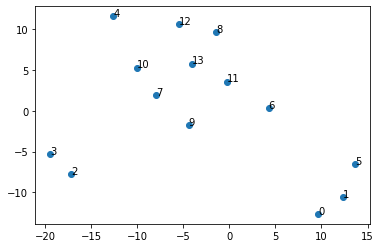

In [ ]:
# TSNE visualization, with node id on

emb  = embed.nodes_embeddings.weight.data.numpy()
tsne_emb = TSNE(n_components = 2, perplexity = 5, learning_rate = 10).fit_transform(emb)

plt.scatter(tsne_emb[:,0], tsne_emb[:,1])
for i in range(len(tsne_emb)):
    plt.annotate(str(i), xy=(tsne_emb[i,0], tsne_emb[i,1]))
plt.show()



In [ ]:
emb.shape

(14, 8)

In [ ]:
train_emb = np.zeros((X_train.shape[0], emb.shape[1]))
for seq in X_train:
  translated_seq = [node_to_ind[e] for e in seq]
  for ind in translated_seq:
    #print(ind)
    train_emb[i] += emb[ind]
  

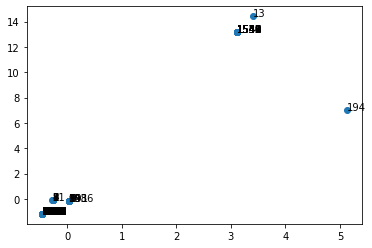

In [ ]:
tsne_emb = TSNE(n_components = 2, perplexity = 5, learning_rate = 10).fit_transform(train_emb)

plt.scatter(tsne_emb[:,0], tsne_emb[:,1])
for i in range(len(tsne_emb)):
    plt.annotate(str(i), xy=(tsne_emb[i,0], tsne_emb[i,1]))
plt.show()

